Przeprowadzić analizę mocy wybranych testów statystycznych w różnych warunkach. Badaniu poddane zostaną testy Kołmogorowa, Lillieforsa, Andersona-Darlinga oraz test Kołmogorowa-Smirnowa, zarówno w klasycznej wersji, jak i z wykorzystaniem transformacji PIT (probability integral transform).

# Zdanie 1
Wpływ rozkładu danych na moc testów 
Zbadanie mocy testów w przypadku, gdy dane pochodzą z różnych rozkładów:

- Rozkład t-Studenta (z uwzględnieniem liczby stopni swobody),
- Rozkład χ2 (z uwzględnieniem liczby stopni swobody),
- Rozkłady normalne o różnych odchyleniach standardowych przy stałej wartości oczekiwanej,
- Rozkłady NIG  i gamma o różnych parametrach.

In [3]:
import numpy as np
import scipy.stats as stats
from statsmodels.stats.diagnostic import lilliefors
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# Funkcja do liczenia PIT
def pit_transform(data, dist_name, **params):
    dist = getattr(stats, dist_name)
    return dist.cdf(data, **params)

# Testy normalności
def test_normality(data, alpha=0.05, anderson_crit_val=1.092):
    results = {}
    results['ks'] = stats.kstest(data, 'norm')[1] < alpha
    results['lilliefors'] = lilliefors(data)[1] < alpha
    results['anderson'] = stats.anderson(data, dist='norm').statistic > anderson_crit_val
    return results

# Test PIT (dla dowolnego rozkładu)
def test_pit(data, dist_name, alpha=0.05, **params):
    pit_data = pit_transform(data, dist_name, **params)
    return stats.kstest(pit_data, 'uniform')[1] < alpha

# Analiza mocy testów dla jednego rozkładu
def run_power_test(generate_sample_func, dist_name=None, pit_params=None, n=100, alpha=0.05, n_sim=1000):
    counters = {'ks': 0, 'lilliefors': 0, 'anderson': 0, 'ks_pit': 0}

    for _ in tqdm(range(n_sim), leave=False):
        sample = generate_sample_func()

        res = test_normality(sample, alpha)
        for key in ['ks', 'lilliefors', 'anderson']:
            counters[key] += res[key]

        if dist_name and pit_params:
            counters['ks_pit'] += test_pit(sample, dist_name, alpha=alpha, **pit_params)

    # Przekształć do mocy (procent odrzuceń H0)
    for key in counters:
        counters[key] = counters[key] / n_sim

    return counters

def plot_power(results_dict, param_name, title):
    plt.figure(figsize=(10, 6))
    for test_name in ['ks', 'anderson', 'ks_pit', 'lilliefors']:
        values = [v.get(test_name, np.nan) for v in results_dict.values()]
        plt.plot(list(results_dict.keys()), values, label=test_name.upper())

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Moc testu (Power)")
    plt.legend()
    plt.tight_layout()
    plt.show()

100%|██████████| 6/6 [00:20<00:00,  3.43s/it]


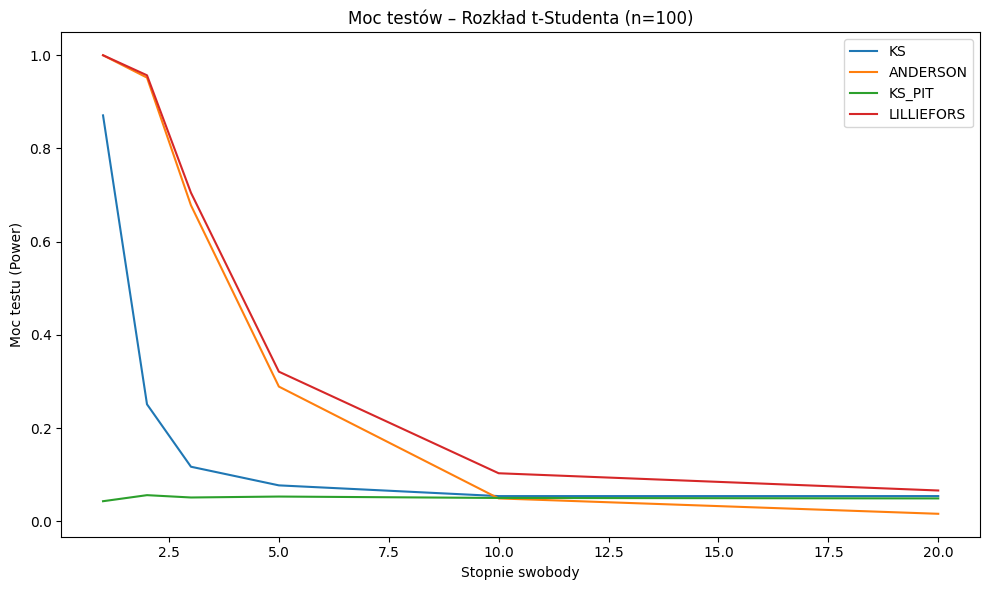

In [4]:
results_t = {}
dfs = [1, 2, 3, 5, 10, 20]
for df in tqdm(dfs):
    results_t[df] = run_power_test(
        generate_sample_func=lambda: stats.t.rvs(df=df, size=100),
        dist_name='t',
        pit_params={'df': df}
    )
plot_power(results_t, "Stopnie swobody", "Moc testów – Rozkład t-Studenta (n=100)")


In [ ]:
results_chi2 = {}
dfs = [1, 2, 3, 5, 10, 20]
for df in tqdm(dfs):
    results_chi2[df] = run_power_test(
        generate_sample_func=lambda: stats.chi2.rvs(df=df, size=100),
        dist_name='chi2',
        pit_params={'df': df}
    )
plot_power(results_chi2, "Stopnie swobody", "Moc testów – Rozkład chi-kwadrat (n=100)")


In [ ]:
results_norm_std = {}
stds = [0.5, 1.0, 1.5, 2.0, 3.0]
for std in tqdm(stds):
    results_norm_std[std] = run_power_test(
        generate_sample_func=lambda: stats.norm.rvs(loc=0, scale=std, size=100),
        dist_name='norm',
        pit_params={'loc': 0, 'scale': std}
    )
plot_power(results_norm_std, "Odchylenie standardowe", "Moc testów – Rozkład normalny (n=100)")


In [ ]:
results_gamma = {}
alphas = [0.5, 1.0, 2.0, 3.0, 5.0]
for a in tqdm(alphas):
    results_gamma[a] = run_power_test(
        generate_sample_func=lambda: stats.gamma.rvs(a=a, size=100),
        dist_name='gamma',
        pit_params={'a': a}
    )
plot_power(results_gamma, "Parametr a", "Moc testów – Rozkład gamma (n=100)")


In [ ]:
results_nig = {}
a_vals = [0.5, 1.0, 2.0, 3.0, 5.0]
for a in tqdm(a_vals):
    results_nig[a] = run_power_test(
        generate_sample_func=lambda: stats.norminvgauss.rvs(a=a, b=0.0, size=100),
        dist_name='norminvgauss',
        pit_params={'a': a, 'b': 0.0}
    )
plot_power(results_nig, "Parametr a", "Moc testów – Rozkład NIG (n=100, b=0)")


In [ ]:
results_sample_size = {}
sizes = [20, 50, 100, 200, 500]
for n in tqdm(sizes):
    results_sample_size[n] = run_power_test(
        generate_sample_func=lambda: stats.t.rvs(df=3, size=n),
        dist_name='t',
        pit_params={'df': 3}
    )
plot_power(results_sample_size, "Rozmiar próbki", "Moc testów – t-Student (df=3)")


# Zadanie 2
Wpływ liczebności danych na moc testów
Analiza mocy testów w zależności od wielkości próbki. Przeanalizować różne liczebności próbki, aby określić, jak zmienia się moc testu w miarę wzrostu liczby obserwacji.

# Zadanie 3
Analiza błędu I rodzaju
Przeprowadzenie symulacji w celu oszacowania odsetka odrzuceń prawdziwej hipotezy zerowej (błąd I rodzaju) w przypadku weryfikacji zgodności z rozkładem NIG oraz gamma. Porównanie wyników klasycznej metody testowania z metodą wykorzystującą PIT.

# Zadanie 4
Wizualizacja wyników
Wyniki analizy przedstawić w formie wykresów ilustrujących moc testów w zależności od:

- Liczebności próbki,
- Parametrów generowanych rozkładów (stopni swobody, odchylenia standardowego, parametry rozkładów NIG i gamma). Każdy wykres zostanie odpowiednio opisany i oznaczony, aby możliwa była łatwa interpretacja wyników.